# Init

In [11]:
library(mdsr)
library(e1071)
library(ROCR)
library(pROC)
library(gridExtra)

# Datasets

In [2]:
census <- read.csv(
  "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
  header = FALSE)
names(census) <- c("age", "workclass", "fnlwgt", "education",
                   "education.num", "marital.status", "occupation", "relationship",
                   "race", "sex", "capital.gain", "capital.loss", "hours.per.week",
                   "native.country", "income")
glimpse(census)

Observations: 32,561
Variables: 15
$ age            <int> 39, 50, 38, 53, 28, 37, 49, 52, 31, 42, 37, 30, 23, ...
$ workclass      <fct>  State-gov,  Self-emp-not-inc,  Private,  Private,  ...
$ fnlwgt         <int> 77516, 83311, 215646, 234721, 338409, 284582, 160187...
$ education      <fct>  Bachelors,  Bachelors,  HS-grad,  11th,  Bachelors,...
$ education.num  <int> 13, 13, 9, 7, 13, 14, 5, 9, 14, 13, 10, 13, 13, 12, ...
$ marital.status <fct>  Never-married,  Married-civ-spouse,  Divorced,  Mar...
$ occupation     <fct>  Adm-clerical,  Exec-managerial,  Handlers-cleaners,...
$ relationship   <fct>  Not-in-family,  Husband,  Not-in-family,  Husband, ...
$ race           <fct>  White,  White,  White,  Black,  Black,  White,  Bla...
$ sex            <fct>  Male,  Male,  Male,  Male,  Female,  Female,  Femal...
$ capital.gain   <int> 2174, 0, 0, 0, 0, 0, 0, 0, 14084, 5178, 0, 0, 0, 0, ...
$ capital.loss   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ hours.per.week 

In [3]:
set.seed(364)
n <- nrow(census)
test_idx <- sample.int(n, size = round(0.2 * n))
train <- census[-test_idx,]
nrow(train)

test <- census[test_idx,]
nrow(test)

[1] 26049

[1] 6512

# Naive Bayes

In [4]:
form <- as.formula("income ~ age + workclass + education + marital.status +
  occupation + relationship + race + sex + capital.gain + capital.loss +
  hours.per.week")

mod_nb <- naiveBayes(form, data = train)
income_nb <- predict(mod_nb, newdata = train)
confusion <- tally(income_nb ~ income, data = train, format = "count")
confusion

sum(diag(confusion)) / nrow(train)

         income
income_nb  <=50K  >50K
    <=50K  18724  3591
    >50K    1119  2615

[1] 0.8191869

This means that the accuracy of the predictions was 81.9% using the normal `predict.naiveBayes` function.

In [5]:
income_probs <- mod_nb %>%
  predict(newdata = train, type = "raw") %>%
  as.data.frame()
head(income_probs, 3)

names(income_probs)

tally(~` >50K` > 0.5, data = income_probs, format = "percent")

tally(~` >50K` > 0.24, data = income_probs, format = "percent")

<=50K,>50K
0.9879029,0.0120971199
0.8560991,0.1439009065
0.9997610,0.0002390345


[1] " <=50K" " >50K"

` >50K` > 0.5
    TRUE    FALSE 
14.33452 85.66548 

` >50K` > 0.24
    TRUE    FALSE 
19.31744 80.68256 

The `tally` functions demonstrate the idea of thresholds. 0.5 and 0.24 are two different thresholds for predicting whether an individual makes more than 50K a year or not. `predict.naiveBayes` uses a default threshold of 0.5. However, setting `type = raw` returns the probabilities, allowing us to set our own thresholds.

In [6]:
pred <- ROCR::prediction(income_probs[, 2], train$income)
perf <- ROCR::performance(pred, 'tpr', 'fpr')
class(perf)
str(perf)

[1] "performance"
attr(,"package")
[1] "ROCR"

Formal class 'performance' [package "ROCR"] with 6 slots
  ..@ x.name      : chr "False positive rate"
  ..@ y.name      : chr "True positive rate"
  ..@ alpha.name  : chr "Cutoff"
  ..@ x.values    :List of 1
  .. ..$ : num [1:22314] 0 0.000706 0.000706 0.000706 0.000706 ...
  ..@ y.values    :List of 1
  .. ..$ : num [1:22314] 0 0.079 0.0802 0.0814 0.082 ...
  ..@ alpha.values:List of 1
  .. ..$ : num [1:22314] Inf 1 1 1 1 ...


The alpha values from above are of interest. I want to know if they are what the `prediction` and `performance` objects use to construct the ROC curve.

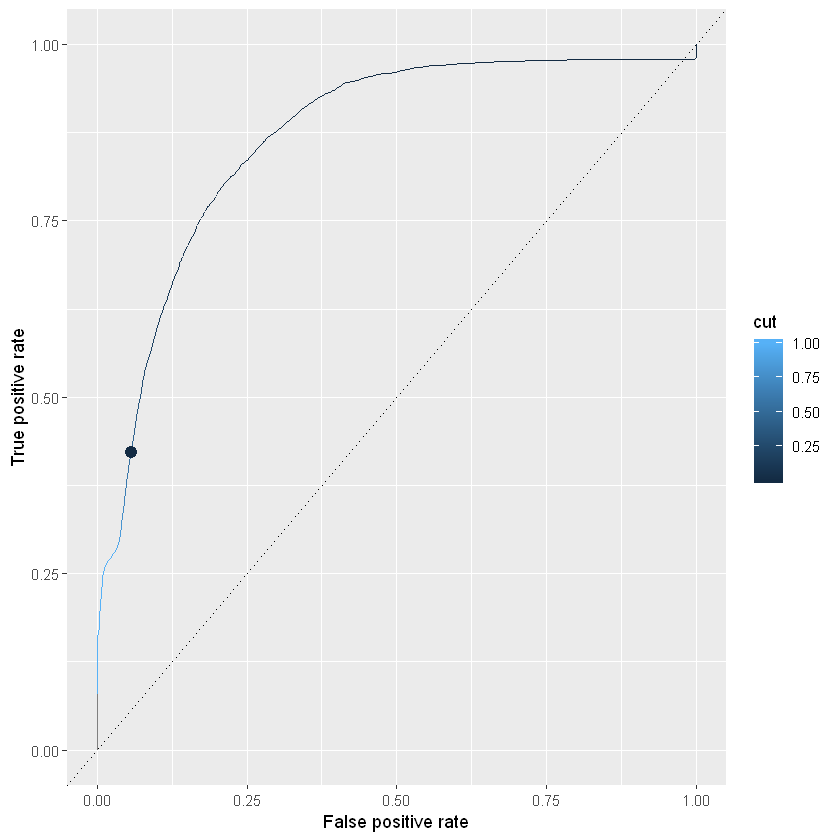

In [7]:
perf_df <- data.frame(perf@x.values, perf@y.values, perf@alpha.values)
names(perf_df) <- c("fpr", "tpr", "cut")
roc <- perf_df %>% ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf@y.name) + xlab(perf@x.name)

tpr <- confusion[" >50K", " >50K"] / sum(confusion[, " >50K"])
fpr <- confusion[" >50K", " <=50K"] / sum(confusion[, " <=50K"])
roc + geom_point(x = fpr, y = tpr, size = 3)

The alpha values are demonstrated by the gradient of the line. The enlarged point on the graph represents the TPR, FPR, and alpha value from the default `predict.naiveBayes` function, whose result was stored in `income_nb`.

# Comparing ROC Curves

This block iterates 1000 times over the raw probabilities generated in `income_probs` and uses different threshold (cut) values to make the predictions. The threshold values are evenly spaced between 0 and 1, exclusive. Then the threshold value, accuracy, TPR, and FPR are stored in a matrix (which is converted to a data frame).

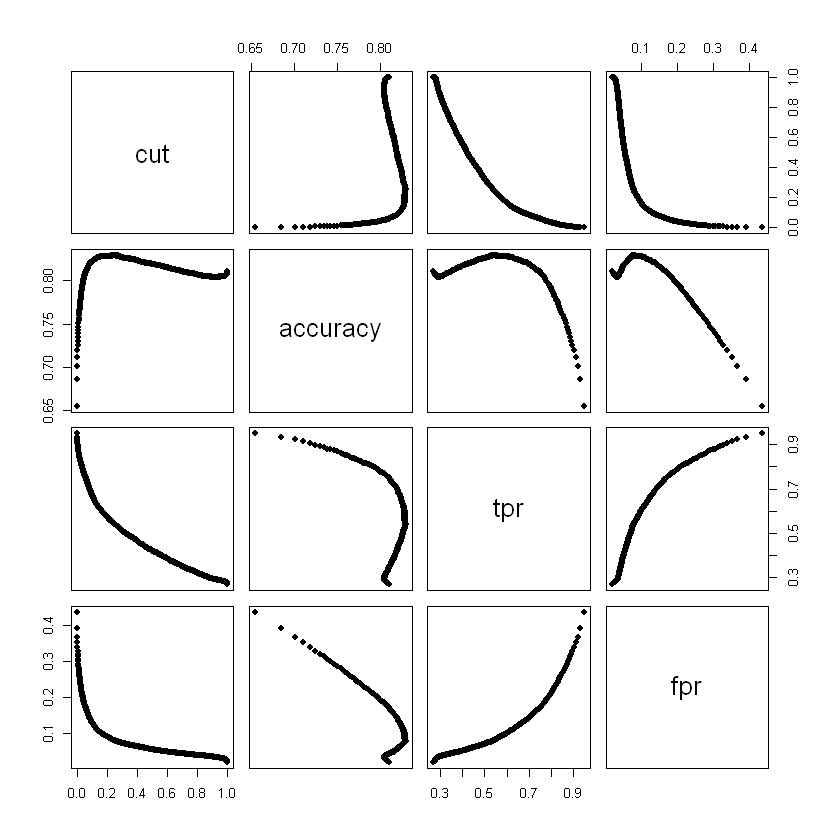

In [8]:
iter <- 1000
cut_matrix <- matrix(nrow = iter, ncol = 4)
for(k in 1:iter) {
  income_nb_cut <- ifelse(income_probs$` >50K` > k/(iter + 1), " >50K", " <=50K") %>% as.factor()

  confusion <- tally(income_nb_cut ~ income, data = train, format = "count")
  
  tpr <- confusion[" >50K", " >50K"] / sum(confusion[, " >50K"])
  fpr <- confusion[" >50K", " <=50K"] / sum(confusion[, " <=50K"])

  cut_matrix[k, 1] <- k/(iter + 1)
  cut_matrix[k, 2] <- sum(diag(confusion)) / nrow(train)
  cut_matrix[k, 3] <- tpr
  cut_matrix[k, 4] <- fpr
}
cut_df <- cut_matrix %>% as.data.frame()
names(cut_df) <- c("cut", "accuracy", "tpr", "fpr")

pairs(cut_df, pch = 19)

Really, the only important scatterplots above are *accuracy vs. cut* and *tpr vs. fpr*.

In [9]:
(best_cut <- cut_df %>% top_n(1, accuracy) %>% select(cut) %>% as.numeric())
(best_acc <- cut_df %>% top_n(1, accuracy) %>% select(accuracy) %>% as.numeric())

income_nb_cut <- ifelse(income_probs$` >50K` > best_cut, " >50K", " <=50K") %>% as.factor()

confusion <- tally(income_nb_cut ~ income, data = train, format = "count")
confusion

[1] 0.2557443

[1] 0.8292065

             income
income_nb_cut  <=50K  >50K
        <=50K  18258  2864
        >50K    1585  3342

The best threshold value (the one that optimizes accuracy), occurs at 0.256, and it generates an accuracy of 82.9%, higher than the 81.9% from earlier.

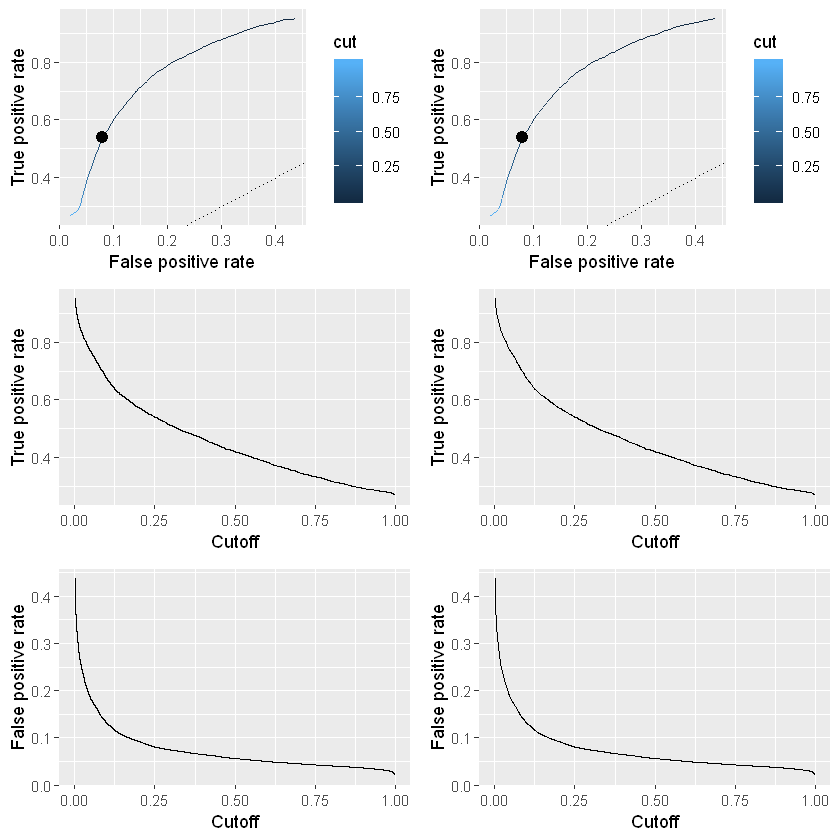

In [10]:
tpr <- confusion[" >50K", " >50K"] / sum(confusion[, " >50K"])
fpr <- confusion[" >50K", " <=50K"] / sum(confusion[, " <=50K"])
roc1 <- perf_df %>% filter(cut >= 1/(iter + 1) & cut <= iter/(iter + 1)) %>% 
  ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf@y.name) + xlab(perf@x.name) +
  geom_point(x = fpr, y = tpr, size = 3, color = "black")
roc2 <- cut_df %>% ggplot(aes(x = fpr, y = tpr, color = cut)) +
  geom_line() + geom_abline(intercept = 0, slope = 1, lty = 3) +
  ylab(perf@y.name) + xlab(perf@x.name) +
  geom_point(x = fpr, y = tpr, size = 3, color = "black")

roc3 <- perf_df %>% filter(cut >= 1/(iter + 1) & cut <= iter/(iter + 1)) %>% 
  ggplot(aes(x = cut, y = tpr)) +
  geom_line() + ylab(perf@y.name) + xlab(perf@alpha.name)
roc4 <- cut_df %>% ggplot(aes(x = cut, y = tpr)) +
  geom_line() + ylab(perf@y.name) + xlab(perf@alpha.name)

roc5 <- perf_df %>% filter(cut >= 1/(iter + 1) & cut <= iter/(iter + 1)) %>% 
  ggplot(aes(x = cut, y = fpr)) +
  geom_line() + ylab(perf@x.name) + xlab(perf@alpha.name)
roc6 <- cut_df %>% ggplot(aes(x = cut, y = fpr)) +
  geom_line() + ylab(perf@x.name) + xlab(perf@alpha.name)

grid.arrange(roc1, roc2, roc3, roc4, roc5, roc6)

The left column of graphs were generated using the `@x.values`, `@y.values`, and `@alpha.values` from the `performance` object. The right column was generated using the values from the `for` loop from earlier. It's apparent that the cutoff/alpha values in the `performance` object represents the threshold values as we know it for Naive Bayes. The enlarged point on the first two graphs was calculated using the best threshold value from before.